In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm
from sklearn.mixture import GaussianMixture

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.gmm.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

GT rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
GT Mode 0: [-5. -5. -5.] +/- [1.  1.5 3.5]
GT Mode 1: [5. 5. 5.] +/- [1.25 0.25 0.25]
GT Mode 2: [-2.  0.  2.] +/- [1.  2.  1.5]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

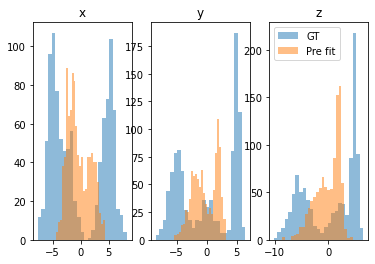

In [4]:
# Make the ground truth GMM grammar.
pyro.set_rng_seed(42)
gt_grammar =SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
root_prototype = Root(gt_grammar.root_node_tf)

# Reset params to values we control (different from prior).
desired_mode_means = [
    torch.tensor([-5., -5., -5.]),
    torch.tensor([5., 5., 5.]),
    torch.tensor([-2., 0., 2.])
]
desired_mode_vars = [
    torch.tensor([1.0, 1.5, 3.5]),
    torch.tensor([1.25, 0.25, 0.25]),
    torch.tensor([1., 2., 1.5])
]
desired_mode_weights = torch.tensor([0.4, 0.4, 0.2])
rule_probs_param = gt_grammar.params_by_node_type["Root"]
rule_probs_param.set(desired_mode_weights)
print("GT rule probs: ", rule_probs_param())
for k, rule_params in enumerate(gt_grammar.rule_params_by_node_type["Root"]):
    mode_name = "Mode_%d" % k
    mean_param = rule_params[0]["mean"]
    mean_param.set(desired_mode_means[k])
    var_param = rule_params[0]["variance"]
    var_param.set(desired_mode_vars[k])
    print("GT Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))
    
    
# Make our fitting grammar. This'll also have randomly sampled means + vars, but
# different ones.
torch.random.manual_seed(3)
fit_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
initial_mode_means = [
    torch.tensor([-2., -2., -2.]),
    torch.tensor([2., 2., 2.]),
    torch.tensor([-1., 0., 1.])
]
initial_mode_vars = [
    torch.tensor([1., 1.5, 3.5]),
    torch.tensor([1.25, 0.25, 0.25]),
    torch.tensor([1., 2., 1.5])
]
initial_mode_weights = torch.tensor([0.333, 0.333, 0.333])
rule_probs_param = fit_grammar.params_by_node_type["Root"]
rule_probs_param.set(desired_mode_weights)
for k, rule_params in enumerate(fit_grammar.rule_params_by_node_type["Root"]):
    mode_name = "Mode_%d" % k
    mean_param = rule_params[0]["mean"]
    mean_param.set(initial_mode_means[k])
    var_param = rule_params[0]["variance"]
    var_param.set(initial_mode_vars[k])
#fit_grammar = deepcopy(gt_grammar)
pre_fit_grammar = deepcopy(fit_grammar)

def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

# Draw random samples from our randomly-initialized GMM
def get_draws_from_grammar(grammar, N_samples):
    samples = []
    for k in tqdm(range(N_samples)):
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))
    return samples

gt_samples = get_draws_from_grammar(gt_grammar, 1000)
pre_fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_pre_fit = get_all_node_xyzs([sample[0] for sample in pre_fit_samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=25, label="GT", alpha=0.5)
    plt.hist(l_pre_fit[:, k], bins=25, label="Pre fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()

In [5]:
# Try parsing this grammar
pyro.set_rng_seed(42)
test_tree = gt_grammar.sample_tree(detach=True)
print(test_tree.get_root().rules[0].parameters)
test_observed = test_tree.get_observed_nodes()
mip_optimized_trees = infer_mle_tree_with_mip_from_proposals(
    gt_grammar, test_observed, {}, verbose=2, N_solutions=3
)

({'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}, {})
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Wed Jan 12 18:01:11 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 31 rows, 15 columns and 67 nonzeros
Model fingerprint: 0xd1a54dc6
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [9e-01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 351.9636972
Presolve removed 30 rows and 12 columns
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Variable types: 0 continuous, 3 integer (3 binary)
Found heuristic solution: objective 21.5640130

Root relaxation: objective 5.302449e+00, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Ga

  0%|          | 0/100 [00:00<?, ?it/s]

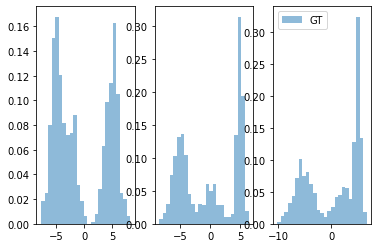

In [6]:
torch.random.manual_seed(43)
N_fit_samples = 100

# Draw an actual fitting dataset.
samples = get_draws_from_grammar(gt_grammar, N_fit_samples)

l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_train[:, k], label="Train", alpha=0.5, bins=25, density=True)
    plt.hist(l_gt[:, k], label="GT", alpha=0.5, bins=25, density=True)
    if k == 2:
        plt.legend()

In [ ]:
# Hand-written EM baseline for GMM: estimate cluster
# association weights, and then apply a closed form update
# to get new best cluster mean and vars. (Like a "soft"
# k-mean.)
    
# Initialize param guesses from pre-fit grammar
weights_init = pre_fit_grammar.params_by_node_type["Root"]().detach()
means_init = []
vars_init = []
for rule_params in pre_fit_grammar.rule_params_by_node_type["Root"]:
    mean = rule_params[0]["mean"]().detach()
    var = rule_params[0]["variance"]().detach()
    means_init.append(mean)
    vars_init.append(var)
means_init = np.stack(means_init)
vars_init = np.stack(vars_init)
print(weights_init, means_init, vars_init)

gmm = GaussianMixture(
    n_components=3,
    covariance_type="diag",
    weights_init=pre_fit_grammar.params_by_node_type["Root"]().detach(),
    means_init=means_init,
    precisions_init=1./vars_init
)

X = points = torch.stack([sample[1][0].translation for sample in samples])
gmm.fit(X)

# Make an EM-fit grammar with those params
em_fit_grammar = deepcopy(pre_fit_grammar)
rule_probs_param = em_fit_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(torch.tensor(gmm.weights_))
print("EM fit rule probs: ", rule_probs_param())
for k, rule_params in enumerate(em_fit_grammar.rule_params_by_node_type["Root"]):
    mean_param = rule_params[0]["mean"]
    var_param = rule_params[0]["variance"]
    mean_param.set(torch.tensor(gmm.means_[k, :]))
    var_param.set(torch.tensor(1./gmm.precisions_[k, :]))
    print("EM-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))
    
# Draw its empirical fit
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
em_fit_samples = get_draws_from_grammar(em_fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_em_fit = get_all_node_xyzs([sample[0] for sample in em_fit_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5, density=True)
    plt.hist(l_em_fit[:, k], bins=25, label="EM fit", alpha=0.5, density=True)
    plt.hist(l_train[:, k], bins=25, label="Train", alpha=0.5, density=True)
    plt.title(label)
    if k == 2:
        plt.legend()

# One-shot parsing with MAP point latent estimates

In [6]:
# Do single-shot fitting of grammar params based on just the optimal parses
one_shot_fit_grammar = deepcopy(pre_fit_grammar)
em = EMWrapper(one_shot_fit_grammar, [sample[1] for sample in samples],
               parsing_strategy="ip_noproposals", do_nlp_refinement=False
)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=3, num_workers=10);

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Final params:  tensor([0.1999, 0.3301, 0.4700])
mean tensor([[-0.6332, -0.1633,  1.5277],
        [-2.2261, -0.3763,  1.7992],
        [-2.3253, -0.5585,  1.6169],
        [-2.2879, -0.6882,  1.6340],
        [-2.2438, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560]])
0:xyz:mean final: tensor([-2.2439, -0.6126,  1.7560])
variance tensor([[4.6226, 0.8209, 6.8300],
        [0.6847, 1.1285, 1.5196],
        [0.4811, 1.2508, 0.8837],
        [0.7866, 1.4193, 0.9127],
        [0.8142, 1.5000, 1.1621],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622]])
0:xyz:variance final: tensor([0.8142, 1.5000, 1.1622])
mean tensor([[-1.3265, -1.2413, -0.1028],
    

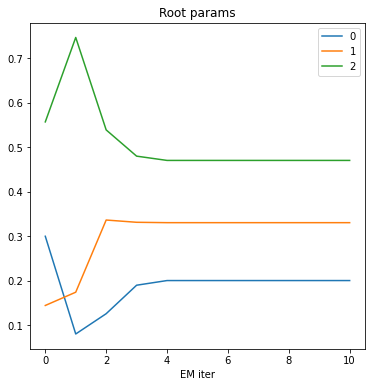

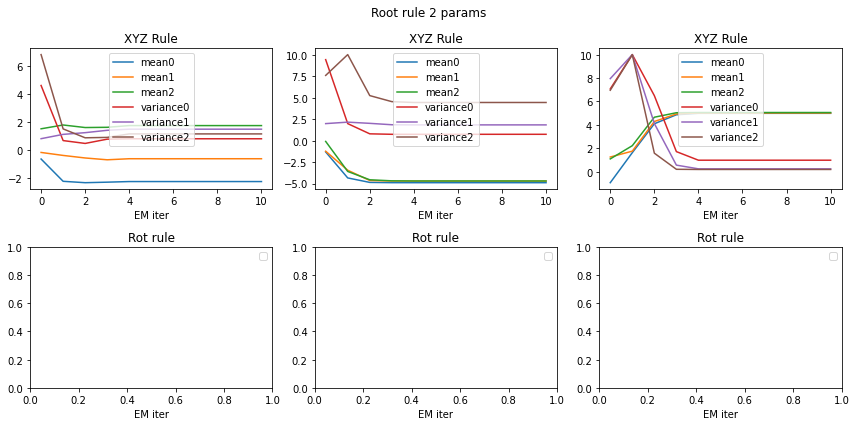

In [7]:
em.plot_grammar_parameter_history(Root)

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'one_shot_fit_grammar' is not defined

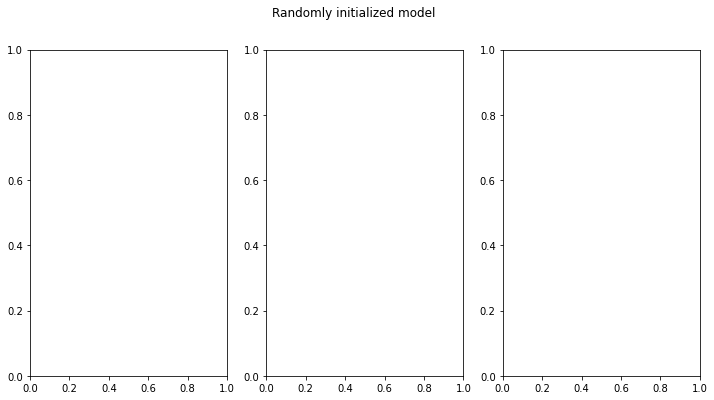

In [18]:
%matplotlib inline
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
def make_figure_for_grammar(one_shot_fit_grammar, axs, N=1000):
    rule_probs_param = one_shot_fit_grammar.params_by_node_type[Root.__name__]
    print("One shot fit rule probs: ", rule_probs_param())
    modes = []
    for k, rule_params in enumerate(one_shot_fit_grammar.rule_params_by_node_type["Root"]):
        mean_param = rule_params[0]["mean"]
        var_param = rule_params[0]["variance"]
        modes.append((mean_param(), var_param()))
        print("One shot-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))

    #fit_samples = get_draws_from_grammar(one_shot_fit_grammar, N)
    l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
    #l_fit = get_all_node_xyzs([sample[0] for sample in fit_samples], Point)
    l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
    xs = np.linspace(-8, 8, 1000)
    for k, label in enumerate("xyz"):
        ax = axs[k]
        ax.hist(l_train[:, k], bins=50, label="Training data", alpha=0.5, density=True)
        #ax.hist(l_gt[:, k], bins=50, label="Test data", alpha=0.5, density=True)
        #plt.hist(l_fit[:, k], bins=50, label="One-shot fit", alpha=0.5, density=True)
        # Plot the mode density
        for mode_k, (prob, mode) in enumerate(zip(rule_probs_param().detach().numpy(), modes)):
            mode = torch.exp(dist.Normal(mode[0][k], mode[1][k]).log_prob(torch.tensor(xs))).detach().numpy() * prob
            ax.plot(xs, mode, label="Mode %d" % mode_k)
        ax.set_title(label)
        if k == 2:
            plt.legend()
            
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 6)
plt.suptitle("Randomly initialized model")

one_shot_fit_grammar.load_state_dict(em.grammar_iters[1])
make_figure_for_grammar(one_shot_fit_grammar, axs)

In [9]:
%matplotlib inline
#Make animation of fitting process
from matplotlib.animation import FuncAnimation
from IPython import display

fig, axs = plt.subplots(1, 3)
#fig.set_dpi(100)
fig.set_size_inches(18, 6)
plt.suptitle("MIP-parse + EM fit")

def update(frame):
    one_shot_fit_grammar.load_state_dict(em.grammar_iters[frame])
    for ax in axs:
        ax.cla()
    make_figure_for_grammar(one_shot_fit_grammar, axs, N=10)
    plt.suptitle("MIP-parse + EM fit, iter %02d" % frame)
    for ax in axs:
        ax.set_xlim([-8, 8.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(len(em.grammar_iters)), blit=False, interval=500.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

One shot fit rule probs:  tensor([0.2995, 0.1439, 0.5566], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-0.6332, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-0.9498,  1.2456,  1.0833], requires_grad=True) +/- tensor([7.0676, 7.9453, 6.9533], grad_fn=<AddBackward0>)
One shot fit rule probs:  tensor([0.2995, 0.1439, 0.5566], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-0.6332, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter con

# Frequentist parsing with MMD + REINFORCE

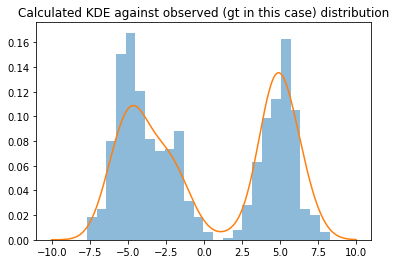

In [232]:
# Note: this is doing really poorly, even when seeded from the GT
# grammar. https://arxiv.org/pdf/2110.13452.pdf
# suggests 

# Do single-shot fitting of grammar params based on just the optimal parses
mmd_fit_grammar = deepcopy(gt_grammar)
#mmd_fit_grammar = deepcopy(pre_fit_grammar)
mmd_fit = SampleBasedFittingWrapper(
    mmd_fit_grammar, [sample[1] for sample in samples],
    distance_metric="kde_poses"
)

plt.title("Calculated KDE against observed (gt in this case) distribution")
plt.hist(l_gt[:, 0], bins=25, label="GT", alpha=0.5, density=True)
xs = np.linspace(-10, 10, 1000)
kern = mmd_fit.observed_kde_kernels_by_type["Point"]
ys = kern.log_prob(torch.tensor(xs).view(-1, 1, 1, 1).expand((-1,) + kern.batch_shape))
ys = torch.logsumexp(ys[:, :, 0, 3], dim=1) - torch.log(torch.tensor(ys.shape[1]))
ys = torch.exp(ys - torch.max(ys) - 2)
plt.plot(xs, ys)

In [234]:
mmd_fit.do_sample_based_fitting(num_iterations=300, num_samples=250, lr=0.005, tqdm=tqdm);

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:1024: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return proxy_loss, torch.tensor(ll_against_obs_kde).mean().detach()


{'rule_params_by_node_type.Root.2.0.mean.unconstrained_value: [-2.  0.  2.], tensor([0.0004, 0.0004, 0.0003])', 'params_by_node_type.Root.unconstrained_value: [-0.91629073 -0.91629073 -1.60943791], tensor([ 3.4067e-03, -3.4764e-03,  6.9636e-05])', 'rule_params_by_node_type.Root.2.0.variance.unconstrained_value: [-2.19722558 -1.38629486 -1.73460172], tensor([ 2.4437e-04, -2.0066e-04,  6.8746e-05])', 'rule_params_by_node_type.Root.0.0.variance.unconstrained_value: [-2.19722558 -1.73460172 -0.61903949], tensor([-1.7691e-04, -5.4422e-04, -9.8065e-05])', 'rule_params_by_node_type.Root.0.0.mean.unconstrained_value: [-5. -5. -5.], tensor([-5.5077e-04, -1.3891e-03, -9.1101e-05])', 'rule_params_by_node_type.Root.1.0.variance.unconstrained_value: [-1.94591095 -3.66356565 -3.66356565], tensor([0.0006, 0.0002, 0.0008])', 'rule_params_by_node_type.Root.1.0.mean.unconstrained_value: [5. 5. 5.], tensor([ 0.0002, -0.0003, -0.0006])'}
0: Loss 1.670855, Proxy Loss -0.003656, Gradient Norm (0.001372 +/- 

44: Loss 1.676253, Proxy Loss 0.012388, Gradient Norm (0.028326 +/- 0.042490)
45: Loss 1.734402, Proxy Loss 0.006473, Gradient Norm (0.028543 +/- 0.042349)
46: Loss 1.684382, Proxy Loss 0.005889, Gradient Norm (0.028328 +/- 0.041807)
47: Loss 1.679929, Proxy Loss 0.008462, Gradient Norm (0.028381 +/- 0.041447)
48: Loss 1.682068, Proxy Loss 0.003840, Gradient Norm (0.027960 +/- 0.040195)
49: Loss 1.730105, Proxy Loss 0.003505, Gradient Norm (0.027318 +/- 0.038829)
{'rule_params_by_node_type.Root.2.0.variance.unconstrained_value: [-2.43912506 -1.13580317 -1.67019261], tensor([ 0.0006, -0.0008,  0.0019])', 'params_by_node_type.Root.unconstrained_value: [-1.17739592 -0.6587994  -1.76062052], tensor([ 0.0818, -0.0729, -0.0089])', 'rule_params_by_node_type.Root.2.0.mean.unconstrained_value: [-2.23009663 -0.2648269   1.739088  ], tensor([0.0011, 0.0086, 0.0034])', 'rule_params_by_node_type.Root.0.0.variance.unconstrained_value: [-2.08309318 -1.46856669 -0.35799705], tensor([ 0.0007, -0.0156, 

91: Loss 1.673482, Proxy Loss 0.021225, Gradient Norm (0.029303 +/- 0.033240)
92: Loss 1.729250, Proxy Loss 0.013518, Gradient Norm (0.029661 +/- 0.033960)
93: Loss 1.684208, Proxy Loss 0.019016, Gradient Norm (0.030274 +/- 0.034911)
94: Loss 1.677113, Proxy Loss 0.016601, Gradient Norm (0.030561 +/- 0.034926)
95: Loss 1.731556, Proxy Loss 0.013701, Gradient Norm (0.030976 +/- 0.035312)
96: Loss 1.684719, Proxy Loss 0.002758, Gradient Norm (0.031939 +/- 0.036668)
97: Loss 1.683014, Proxy Loss 0.009726, Gradient Norm (0.032546 +/- 0.038132)
98: Loss 1.722954, Proxy Loss 0.007634, Gradient Norm (0.033027 +/- 0.038978)
99: Loss 1.682821, Proxy Loss 0.010078, Gradient Norm (0.033489 +/- 0.039981)
{'params_by_node_type.Root.unconstrained_value: [-1.30269304 -0.62198333 -1.3437695 ], tensor([-0.0524,  0.1011, -0.0487])', 'rule_params_by_node_type.Root.0.0.mean.unconstrained_value: [-4.70578588 -4.40918332 -4.44435351], tensor([ 0.0128, -0.0260, -0.0043])', 'rule_params_by_node_type.Root.0.0.

141: Loss 1.664207, Proxy Loss -0.021087, Gradient Norm (0.032039 +/- 0.026741)
142: Loss 1.729590, Proxy Loss -0.014054, Gradient Norm (0.032180 +/- 0.026887)
143: Loss 1.722403, Proxy Loss -0.009124, Gradient Norm (0.032474 +/- 0.027330)
144: Loss 1.674940, Proxy Loss -0.005172, Gradient Norm (0.032462 +/- 0.027619)
145: Loss 1.686326, Proxy Loss -0.025515, Gradient Norm (0.031866 +/- 0.027149)
146: Loss 1.685413, Proxy Loss -0.013036, Gradient Norm (0.032119 +/- 0.027656)
147: Loss 1.682776, Proxy Loss -0.012371, Gradient Norm (0.032160 +/- 0.028295)
148: Loss 1.685300, Proxy Loss -0.016108, Gradient Norm (0.032479 +/- 0.028729)
149: Loss 1.734647, Proxy Loss -0.014003, Gradient Norm (0.033206 +/- 0.029725)
{'rule_params_by_node_type.Root.0.0.variance.unconstrained_value: [-2.87629034 -0.90728258 -0.30277183], tensor([ 0.0145, -0.0121,  0.0072])', 'rule_params_by_node_type.Root.1.0.mean.unconstrained_value: [4.66233827 4.820835   5.0104201 ], tensor([-0.0089,  0.0211,  0.0333])', 'p

191: Loss 1.729688, Proxy Loss -0.007630, Gradient Norm (0.048533 +/- 0.072077)
192: Loss 1.687241, Proxy Loss -0.010263, Gradient Norm (0.049123 +/- 0.072915)
193: Loss 1.683372, Proxy Loss 0.000150, Gradient Norm (0.049684 +/- 0.073638)
194: Loss 1.719183, Proxy Loss -0.015073, Gradient Norm (0.049934 +/- 0.073736)
195: Loss 1.729493, Proxy Loss -0.003106, Gradient Norm (0.049591 +/- 0.072124)
196: Loss 1.732268, Proxy Loss -0.001819, Gradient Norm (0.049742 +/- 0.071801)
197: Loss 1.721072, Proxy Loss 0.005679, Gradient Norm (0.049879 +/- 0.071175)
198: Loss 1.730721, Proxy Loss 0.007724, Gradient Norm (0.049757 +/- 0.070134)
199: Loss 1.720310, Proxy Loss 0.005364, Gradient Norm (0.049715 +/- 0.069539)
{'rule_params_by_node_type.Root.1.0.mean.unconstrained_value: [5.02839799 4.89133075 4.81905594], tensor([-0.0327, -0.0602, -0.0541])', 'rule_params_by_node_type.Root.1.0.variance.unconstrained_value: [-2.83579577 -3.35043923 -4.32113292], tensor([0.0043, 0.0089, 0.0026])', 'rule_par

241: Loss 1.683122, Proxy Loss 0.002085, Gradient Norm (0.034241 +/- 0.023164)
242: Loss 1.731434, Proxy Loss 0.043955, Gradient Norm (0.033886 +/- 0.022652)
243: Loss 1.728375, Proxy Loss 0.017603, Gradient Norm (0.034870 +/- 0.023481)
244: Loss 1.733275, Proxy Loss 0.023173, Gradient Norm (0.035603 +/- 0.024663)
245: Loss 1.681913, Proxy Loss 0.023646, Gradient Norm (0.036892 +/- 0.026592)
246: Loss 1.676543, Proxy Loss 0.022989, Gradient Norm (0.037503 +/- 0.027920)
247: Loss 1.724519, Proxy Loss 0.024531, Gradient Norm (0.037983 +/- 0.029112)
248: Loss 1.729448, Proxy Loss 0.037748, Gradient Norm (0.037572 +/- 0.029109)
249: Loss 1.676902, Proxy Loss 0.024746, Gradient Norm (0.038536 +/- 0.030775)
{'params_by_node_type.Root.unconstrained_value: [-1.07485521 -0.38731893 -1.96089943], tensor([-0.0689,  0.0723, -0.0034])', 'rule_params_by_node_type.Root.2.0.mean.unconstrained_value: [-2.54287419 -1.50054778  2.10183843], tensor([ 0.0080,  0.0135, -0.0067])', 'rule_params_by_node_type.

291: Loss 1.722399, Proxy Loss 0.005122, Gradient Norm (0.079540 +/- 0.083703)
292: Loss 1.728589, Proxy Loss 0.001772, Gradient Norm (0.079319 +/- 0.082796)
293: Loss 1.724530, Proxy Loss 0.008352, Gradient Norm (0.078930 +/- 0.082062)
294: Loss 1.687403, Proxy Loss -0.018035, Gradient Norm (0.077815 +/- 0.079638)
295: Loss 1.684732, Proxy Loss -0.006694, Gradient Norm (0.077150 +/- 0.078355)
296: Loss 1.688770, Proxy Loss -0.004941, Gradient Norm (0.076719 +/- 0.076972)
297: Loss 1.724665, Proxy Loss 0.002752, Gradient Norm (0.077015 +/- 0.077473)
298: Loss 1.683627, Proxy Loss -0.001264, Gradient Norm (0.076513 +/- 0.076612)
299: Loss 1.689324, Proxy Loss -0.013966, Gradient Norm (0.075603 +/- 0.074886)


Text(0, 0.5, 'MMD Estimate')

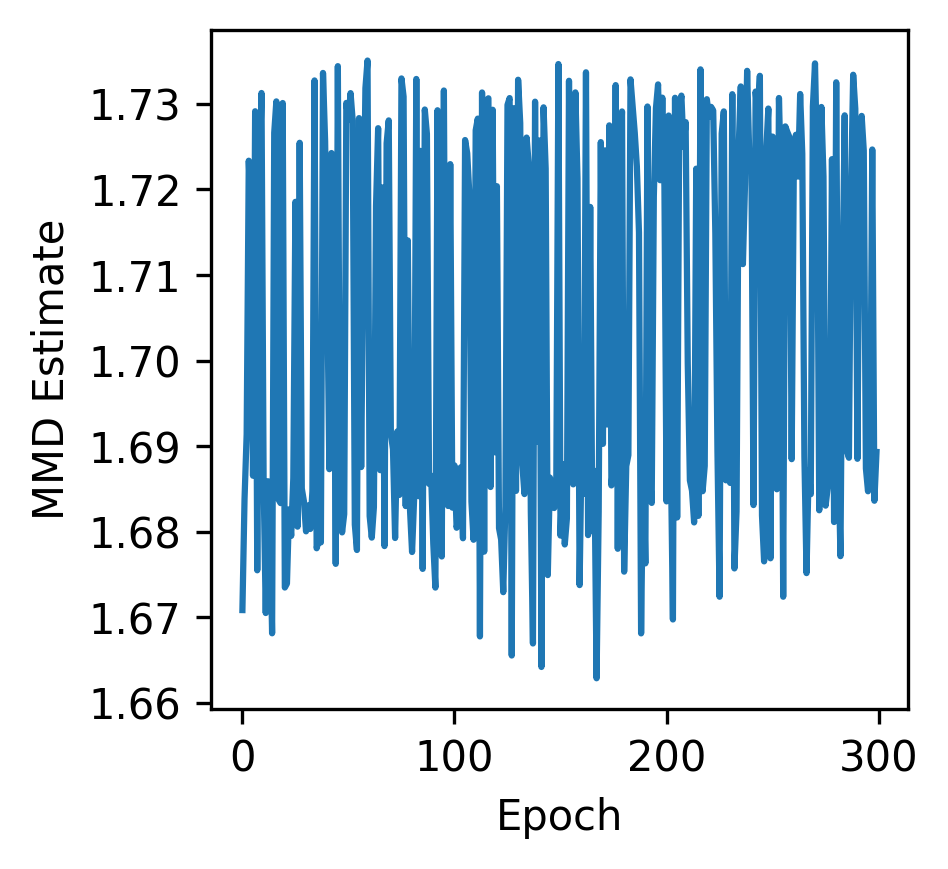

In [236]:
plt.figure(dpi=300).set_size_inches(3, 3)
plt.plot(mmd_fit.loss_iters)
plt.xlabel("Epoch")
plt.ylabel("MMD Estimate")

In [235]:
%matplotlib inline
#Make animation of fitting process
from matplotlib.animation import FuncAnimation
from IPython import display

fig, axs = plt.subplots(1, 3)
#fig.set_dpi(100)
fig.set_size_inches(18, 6)
plt.suptitle("Sample-baseb Fit")

skip_N = 10
def update(frame):
    mmd_fit_grammar.load_state_dict(mmd_fit.grammar_iters[frame])
    for ax in axs:
        ax.cla()
    make_figure_for_grammar(mmd_fit_grammar, axs, N=10)
    plt.suptitle("Sample-based fit, iter %02d" % frame)
    for ax in axs:
        ax.set_xlim([-8, 8.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(0, len(mmd_fit.grammar_iters), skip_N), blit=False, interval=250.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

One shot fit rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-5., -5., -5.], requires_grad=True) +/- tensor([1.0000, 1.5000, 3.5000], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([5., 5., 5.], requires_grad=True) +/- tensor([1.2500, 0.2500, 0.2500], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-2.,  0.,  2.], requires_grad=True) +/- tensor([1.0000, 2.0000, 1.5000], grad_fn=<AddBackward0>)
One shot fit rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-5., -5., -5.], requires_grad=True) +/- tensor([1.0000, 1.5000, 3.5000], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([5., 5., 5.], requires_grad=True) +/- tensor([1.2500, 0.2500, 0.2500], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-2.,  0.,  2.], requires_grad=True) +/- tensor([1

One shot fit rule probs:  tensor([0.3079, 0.3921, 0.3000], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-5.0795, -4.1987, -4.2870], requires_grad=True) +/- tensor([0.5779, 2.7820, 4.4698], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([4.6799, 4.8972, 5.1016], requires_grad=True) +/- tensor([0.6963, 0.3292, 0.1626], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-2.4858, -0.8964,  1.2625], requires_grad=True) +/- tensor([1.3173, 3.7307, 0.9173], grad_fn=<AddBackward0>)
One shot fit rule probs:  tensor([0.3278, 0.3850, 0.2872], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-5.1774, -4.1598, -4.2923], requires_grad=True) +/- tensor([0.5334, 2.8756, 4.2488], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([4.6623, 4.8208, 5.0104], requires_grad=True) +/- tensor([0.6772, 0.3485, 0.1618], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containin

One shot fit rule probs:  tensor([0.4068, 0.4591, 0.1341], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-4.6768, -3.9895, -5.0186], requires_grad=True) +/- tensor([0.5627, 4.6468, 2.7632], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([4.9042, 5.1644, 5.2320], requires_grad=True) +/- tensor([0.9525, 0.2919, 0.1977], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-2.8526, -1.7267,  2.1765], requires_grad=True) +/- tensor([1.4947, 6.7775, 1.5620], grad_fn=<AddBackward0>)
One shot fit rule probs:  tensor([0.4393, 0.4196, 0.1411], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-4.5817, -3.9798, -5.0094], requires_grad=True) +/- tensor([0.6160, 4.7980, 2.8929], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([4.8055, 5.0613, 5.1164], requires_grad=True) +/- tensor([1.0519, 0.3111, 0.2197], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containin